In [8]:
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,InputLayer
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from keras import Input
from tensorflow.estimator import Estimator
from sklearn.utils.class_weight import compute_class_weight

In [9]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [10]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, 'completed')
    return image_paths,labels

In [11]:
train = pd.DataFrame();
train['image'], train['label'] = createdataframe(TRAIN_DIR)

angry completed
disgusted completed
fearful completed
happy completed
neutral completed
sad completed
surprised completed


In [12]:
print(train)

                                  image      label
0            images/train\angry\im0.png      angry
1            images/train\angry\im1.png      angry
2           images/train\angry\im10.png      angry
3          images/train\angry\im100.png      angry
4         images/train\angry\im1000.png      angry
...                                 ...        ...
28704  images/train\surprised\im995.png  surprised
28705  images/train\surprised\im996.png  surprised
28706  images/train\surprised\im997.png  surprised
28707  images/train\surprised\im998.png  surprised
28708  images/train\surprised\im999.png  surprised

[28709 rows x 2 columns]


In [13]:
test = pd.DataFrame();
test['image'], test['label'] = createdataframe(TEST_DIR)

angry completed
disgusted completed
fearful completed
happy completed
neutral completed
sad completed
surprised completed


In [14]:
print(test)
print(test['image'])

                               image      label
0          images/test\angry\im0.png      angry
1          images/test\angry\im1.png      angry
2         images/test\angry\im10.png      angry
3        images/test\angry\im100.png      angry
4        images/test\angry\im101.png      angry
...                              ...        ...
7173  images/test\surprised\im95.png  surprised
7174  images/test\surprised\im96.png  surprised
7175  images/test\surprised\im97.png  surprised
7176  images/test\surprised\im98.png  surprised
7177  images/test\surprised\im99.png  surprised

[7178 rows x 2 columns]
0            images/test\angry\im0.png
1            images/test\angry\im1.png
2           images/test\angry\im10.png
3          images/test\angry\im100.png
4          images/test\angry\im101.png
                     ...              
7173    images/test\surprised\im95.png
7174    images/test\surprised\im96.png
7175    images/test\surprised\im97.png
7176    images/test\surprised\im98.png
7177    i

In [15]:
def extract_features(images):
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}  
    features = []

    for image_path in tqdm(images):
        image_path = os.path.normpath(image_path)

        # Skip non-image files
        if not os.path.splitext(image_path)[1].lower() in valid_extensions:
            print(f"Skipping non-image file: {image_path}")
            continue

        try:
            img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
            img = np.array(img)
            features.append(img)
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            continue

    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [16]:
print(train['image'].head())


0       images/train\angry\im0.png
1       images/train\angry\im1.png
2      images/train\angry\im10.png
3     images/train\angry\im100.png
4    images/train\angry\im1000.png
Name: image, dtype: object


In [96]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [97]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [98]:
np.save('train_features.npy', train_features)
np.save('test_features.npy', test_features)

In [17]:
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')

In [18]:
x_train = train_features/255.0
x_test = test_features/255.0

In [19]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [20]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [21]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

In [22]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [23]:
# convolutional layers

model = Sequential()
model.add(InputLayer(input_shape=(48, 48, 1)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(7, activation='softmax'))

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [ ]:
history = model.fit(x = x_train, y = y_train, batch_size = 128, epochs = 100, validation_data = (x_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 2235s 78ms/step - loss: 2.1758 - accuracy: 0.2313 - val_loss: 1.8188 - val_accuracy: 0.2471
Epoch 2/100
28709/28709 [==============================] - 17s 579us/step - loss: 1.8188 - accuracy: 0.2492 - val_loss: 1.8146 - val_accuracy: 0.2471
Epoch 3/100
28709/28709 [==============================] - 16s 567us/step - loss: 1.8144 - accuracy: 0.2505 - val_loss: 1.8152 - val_accuracy: 0.2471
Epoch 4/100
28709/28709 [==============================] - 16s 564us/step - loss: 1.8126 - accuracy: 0.2512 - val_loss: 1.8133 - val_accuracy: 0.2471
Epoch 5/100
28709/28709 [==============================] - 16s 564us/step - loss: 1.8115 - accuracy: 0.2513 - val_loss: 1.8133 - val_accuracy: 0.2471
Epoch 6/100
28709/28709 [==============================] - 16s 562us/step - loss: 1.8115 - accuracy: 0.2513 - val_loss: 1.8137 - val_accuracy: 0.2471
Epoch 7/100
28709/28709 [=========================

Epoch 55/100
28709/28709 [==============================] - 17s 609us/step - loss: 1.8103 - accuracy: 0.2513 - val_loss: 1.8211 - val_accuracy: 0.2471
Epoch 56/100
28709/28709 [==============================] - 17s 591us/step - loss: 1.8106 - accuracy: 0.2513 - val_loss: 1.8140 - val_accuracy: 0.2471
Epoch 57/100
28709/28709 [==============================] - 16s 569us/step - loss: 1.8105 - accuracy: 0.2513 - val_loss: 1.8140 - val_accuracy: 0.2471
Epoch 58/100
28709/28709 [==============================] - 16s 568us/step - loss: 1.8103 - accuracy: 0.2513 - val_loss: 1.8144 - val_accuracy: 0.2471
Epoch 59/100
12800/28709 [============>.................] - ETA: 8s - loss: 1.8118 - accuracy: 0.2506

In [36]:
model_json = model.to_json()
with open("Emotiondetector.json","w") as json_file:
    json_file.write(model_json)
model.save("Emotiondetector.keras")

In [24]:
from keras.models import model_from_json

In [25]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [31]:
def ef(image):
    img = load_img(image,color_mode = 'grayscale')
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

Original image is of angry
model prediction is  neutral


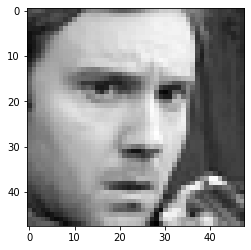

In [33]:
image = 'images/train/angry/im0.png'
print("Original image is of angry")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap = 'gray')

Original image is of happy
model prediction is  neutral


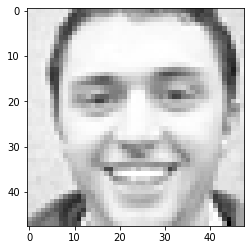

In [35]:
image = 'images/train/happy/im7.png'
print("Original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap = 'gray')